## Final Project Submission

Please fill out:
* Student name: Jack Otieno
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Nikita Njoroge
* Blog post URL:


In [85]:
# Your code here - remember to use markdown cells for comments as well!

# OVERVIEW
Microsoft wants to launch a new movie studio, and there are important factors to consider for optimizing profits.

By analyzing historical data, we uncovered data-driven tips for ensuring a production is high performing with an efficient return on investment.

# BUSINESS PROBLEM
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create.

There are many unknown factors associated with how to make a profit. 1.What genre should microsoft produce? 2.What are the best selling movies? 3.Which languages have high prevalence of selling?

# DATA UNDERSTANDING
We are using movie datasets from 2 different sources:

1.IMDb 2.TheMovieDB

The data includes information on movie genres, titles, runtime, production expense, foreign & domestic box office gross, production studio name, and release dates.

With these datasets, we will search for insights in box office performence and user ratings compared to various factors like genre, personnel, runtime, production budget and release time.

In [86]:
# import standard packages
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import csv
import zipfile
import seaborn as sns

In [87]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:

    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./zippedData/')
# Create connection to IMDb DB
con = sqlite3.connect('./zippedData/im.db')

#bom.movie_gross.csv.gz
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

# DATA PREPARATION
Out of the available datasets, IMDb is the largest, with useful data on runtime, genres, and personnel. It's also more convenient to select which of these values we'd like to look at, as each data set has a tconst column that allows them to be stitched together. For this reason, it would more helpful if IMDb had associated financial information that would allow a broader dataset to draw conclusions from. Unfortunately, IMDb lacks box office or budget data, so it needs to be merged with The Numbers, Box Office Mojo or TheMovieDB data set. These four are collectively the most useful and what we'll be basing our recommendations on.

# DATA CLEANING

1.ANALYSING THE POPULAR GENRE

In [88]:
#import sqlite3 in order to connect to the database
import sqlite3

conn = sqlite3.connect('./zippedData/im.db')
cur = conn.cursor()

In [89]:
cur.execute(""" SELECT name FROM sqlite_master WHERE type = "table"; """)

In [90]:
#viewing all the available tables
table_name = cur.fetchall()
table_name

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [91]:
#vieving the first five rows
movie_ratings = pd.read_sql(""" 
SELECT *
FROM movie_ratings;
""", conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [92]:
#viewing the first five rows
movie_basics = pd.read_sql(""" 
SELECT *
FROM movie_basics;
""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [93]:
#join average rating and genres to get data of interest
#get the first five rows
genre_rating =pd.read_sql("""
SELECT genres, averagerating
FROM movie_ratings
JOIN movie_basics
USING(movie_id);
""", conn)
genre_rating.head()

,genres,averagerating
0,Romance,8.3
1,Documentary,8.9
2,Drama,6.4
3,"Action,Adventure,Fantasy",4.2
4,"Mystery,Thriller",6.5


In [94]:
#getting infromation therein
genre_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   genres         73052 non-null  object 
 1   averagerating  73856 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [95]:
#finding missing values
missing_values = genre_rating.isnull().sum().sort_values(ascending = False)
missing_values

genres           804
averagerating      0
dtype: int64

In [96]:
#Check the total number of rows and columns in the dataframe
genre_rating.shape

(73856, 2)

In [97]:
#Remove white space 
# Assuming genre_rating is your DataFrame

# Check if the value is not None or NaN, and then split the 'genres' string by ',' and remove white spaces from each genre
genre_rating['genres'] = genre_rating['genres'].apply(lambda x: [genre.strip() for genre in x.split(",")] if isinstance(x, str) else [])

# Now, each element in the 'genres' column will be a list of genres without white spaces, or an empty list if the value was None or NaN



In [98]:
#loop over the genre and match it with indexes
for index, row in genre_rating.iterrows():
    if row['genres']:
        for genre in row['genres']:
            genre_rating.loc[index, genre] = 1

In [99]:
#Displaying the genre
cols = list(genre_rating.columns[10:])
cols

['Comedy',
 'Biography',
 'Sport',
 'War',
 'Sci-Fi',
 'Animation',
 'Crime',
 'History',
 'Horror',
 'Music',
 'Family',
 'Musical',
 'News',
 'Western',
 'Reality-TV',
 'Adult',
 'Game-Show',
 'Short']

In [100]:
#create dictionary of genres and counts as i:j pairings using for loop to 
#find the sum for bools for each genre
genre_and_count_dict = {}
for col in cols:
    count = genre_rating[col].sum() 
    genre_and_count_dict[col] = count
genre_and_count_dict

{'Comedy': 17290.0,
 'Biography': 3809.0,
 'Sport': 1179.0,
 'War': 853.0,
 'Sci-Fi': 2206.0,
 'Animation': 1743.0,
 'Crime': 4611.0,
 'History': 2825.0,
 'Horror': 7674.0,
 'Music': 1968.0,
 'Family': 3412.0,
 'Musical': 721.0,
 'News': 579.0,
 'Western': 280.0,
 'Reality-TV': 17.0,
 'Adult': 3.0,
 'Game-Show': 2.0,
 'Short': 1.0}

In [101]:
#sort dictionary values 
sorted_dict = sorted(genre_and_count_dict.values(), reverse=True)[9]
top_10_genre_and_count_dict = {k: v for k, v in genre_and_count_dict.items() 
                                if v >= sorted_dict}
sorted_dict

1179.0

In [102]:
#listinsting top 10 counts for plotting
x_genre_count = list(top_10_genre_and_count_dict.keys())
y_genre_count = list(top_10_genre_and_count_dict.values())

Visualising the top 10 liked genres

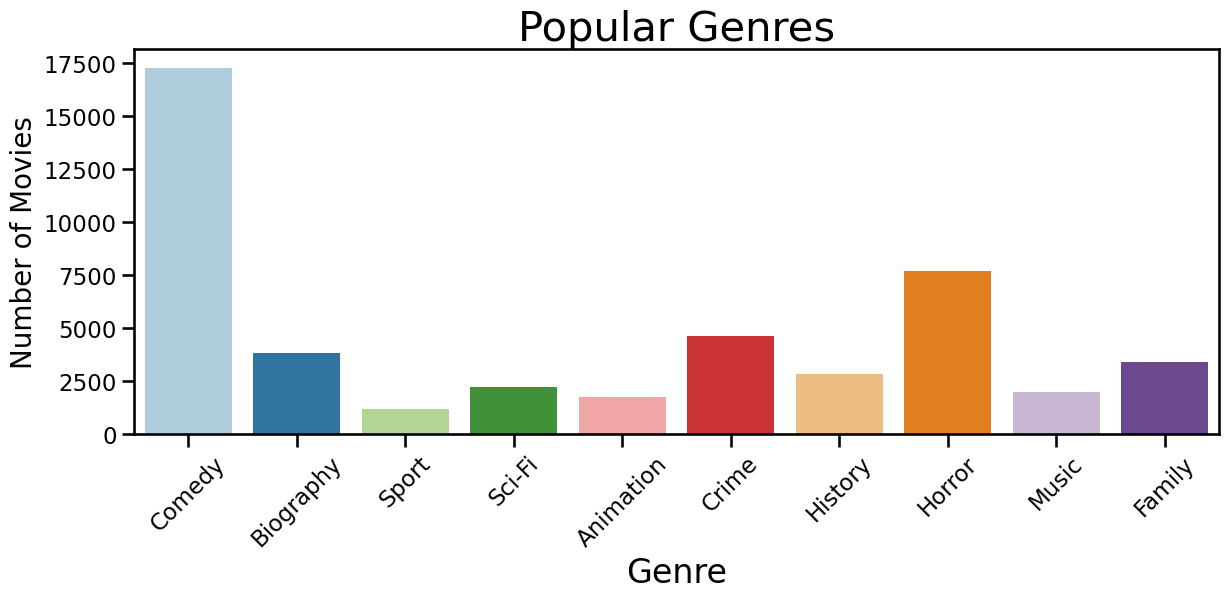

In [103]:
fig, ax = plt.subplots(figsize=(14,5))
sns.axes_style('darkgrid')
sns.set_context('talk') 
sns.barplot(x=x_genre_count, y=y_genre_count,palette='Paired')
plt.title('Popular Genres', fontsize=30)
plt.xticks(rotation=45)
plt.ylabel('Number of Movies', fontsize=20)
plt.xlabel('Genre', fontsize=24) 
plt.show()

Based on the above visualisation it is evident that the most popular genre of movies is comedy. Then horror and family.

# 2.DATA ANALYSIS FOR MOST PROFITABLE MOVIES AND YEAR

In [104]:
#load data for movie_gross and year and display the first five
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [105]:
#display the last five
movie_gross.tail()

,title,studio,domestic_gross,foreign_gross,year
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018
3386,An Actor Prepares,Grav.,1700.0,NaN,2018


In [106]:
#check the movie_gross data information
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [107]:
#Checking for any missing values in the movie_gross data
missing_values = movie_gross.isnull().sum().sort_values(ascending = False)
missing_values

foreign_gross     1350
domestic_gross      28
studio               5
title                0
year                 0
dtype: int64

In [108]:
#Check the total number of rows and columns in the dataframe
movie_gross.shape

(3387, 5)

In [109]:
#drop rows with missing values
movie_gross.dropna(inplace=True)

In [110]:
#New rows and columns
movie_gross.shape

(2007, 5)

In [111]:
 #create a column of profit to enable you to see the best selling movie
import pandas as pd

# Ensure 'foreign_gross' and 'domestic_gross' are numeric.
# This is crucial if your data might include non-numeric values.
movie_gross['foreign_gross'] = pd.to_numeric(movie_gross['foreign_gross'], errors='coerce')
movie_gross['domestic_gross'] = pd.to_numeric(movie_gross['domestic_gross'], errors='coerce')

# Calculate 'movie_profit' by subtracting 'domestic_gross' from 'foreign_gross'
movie_gross['movie_profit'] = movie_gross['foreign_gross'] - movie_gross['domestic_gross']



In [112]:
# Check for most profitable movies in the last eight years
top_profitable_movies_in8years = movie_gross.sort_values('movie_profit',ascending = False).iloc[:8]
top_profitable_movies_in8years

,title,studio,domestic_gross,foreign_gross,year,movie_profit
2764,Wolf Warrior 2,HC,2700000.0,867600000.0,2017,864900000.0
1477,Transformers: Age of Extinction,Par.,245400000.0,858600000.0,2014,613200000.0
328,Harry Potter and the Deathly Hallows Part 2,WB,381000000.0,960500000.0,2011,579500000.0
3091,Operation Red Sea,WGUSA,1500000.0,577700000.0,2018,576200000.0
330,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,2011,563500000.0
731,Ice Age: Continental Drift,Fox,161300000.0,715900000.0,2012,554600000.0
2335,The Mermaid (Mei ren yu),Sony,3200000.0,550600000.0,2016,547400000.0
3092,Detective Chinatown 2,WB,2000000.0,542100000.0,2018,540100000.0


# Visualization for the top profitable movies in the last eight years

In [113]:
height_top_profitable_movies_in8years = sorted(movie_gross.sort_values(by = 'movie_profit', ascending = False)[:8]['movie_profit'].tolist())
top_profitable_movies_in8years = movie_gross.sort_values(by = 'movie_profit', ascending = False)['title'][:8].tolist()
height_top_profitable_movies_in8years.reverse()

In [114]:
for i in range(len(height_top_profitable_movies_in8years)):
    height_top_profitable_movies_in8years[i] /= 1000000
    

(500.0, 900.0)

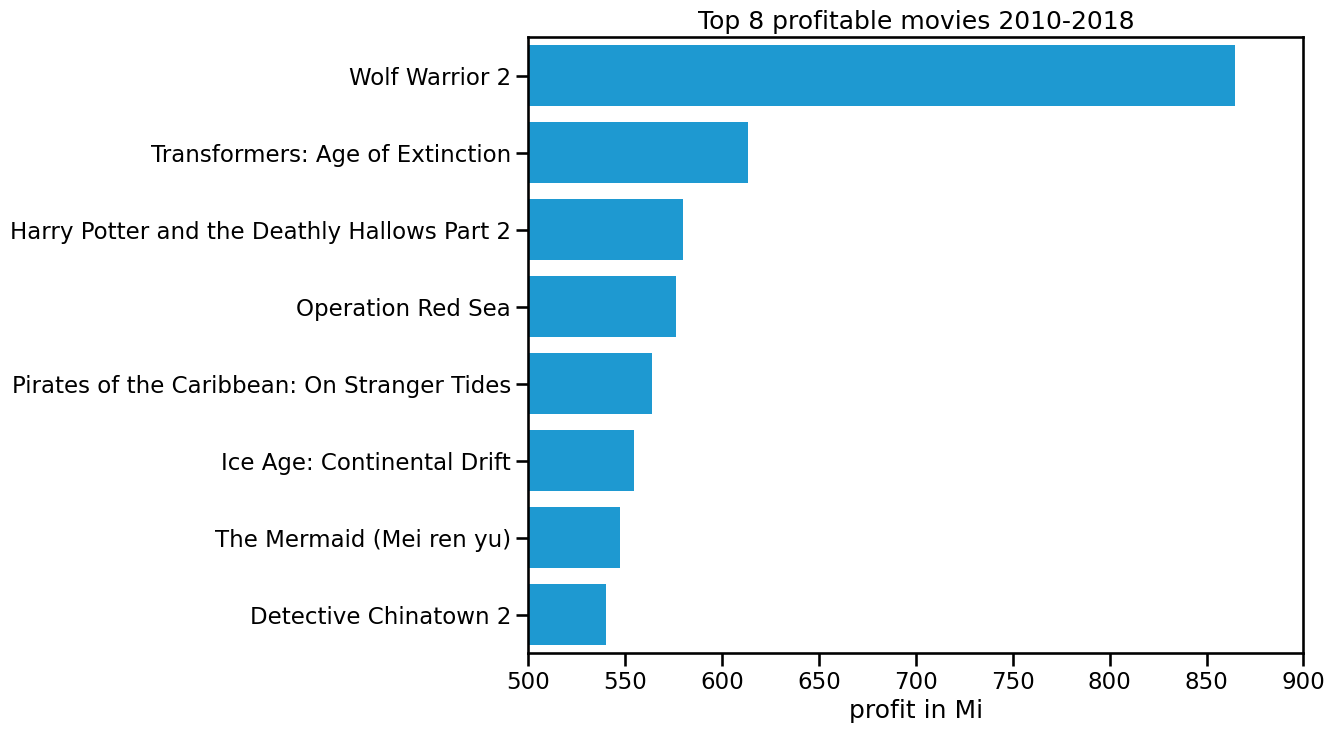

In [115]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0.75, 1.8)
barplot = sns.barplot(x =height_top_profitable_movies_in8years, y =top_profitable_movies_in8years , color = '#00A4EF')
barplot.set(title = 'Top 8 profitable movies 2010-2018',xlabel = 'profit in Mi')
ax.set_xlim(500, 900)
# sns.set_style('ticks')
# plt.savefig('profit1.png',bbox_inches = 'tight')

From the above visualization it is evident that the top profitable movie is 'Wolf Warrior 2'.

# Recommendations

Based on the above data Analysis I recoomend microsoft to:
1.Release comedy movies, horror movies, crime movies and family movies in order for them to gain high profit.
2.The most profitable movie is 'Wolf Warrior'.
3.The should mostly concentrate more on releasing comedy movies.